## Importing Libraries

In [1]:
import pandas as pd
from pypfopt.expected_returns import mean_historical_return
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import discrete_allocation
from pypfopt import expected_returns
from pypfopt import risk_models
from pypfopt import EfficientFrontier
from pypfopt import objective_functions
from pypfopt import base_optimizer
from pypfopt.discrete_allocation import DiscreteAllocation
from pypfopt.hierarchical_portfolio import HRPOpt

C:\Users\ruchd\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\ruchd\anaconda3\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\ruchd\anaconda3\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


## Getting the Data 2010 July till 2020 June

In [2]:
# Define the ticker list
tickers_list = ['AAPL', 'WMT', 'MU', 'BA','GOOG','GE','AMD','BAC','T','UAA','XOM','RRC','PFE','JPM','SBUX']

#BABA & GM removed as no data available for 2010

start_date ='2010-7-1'
end_date ='2020-6-30'

# Fetch the data
import yfinance as yf
data = yf.download(tickers_list,start = start_date,end = end_date)['Adj Close']
#print(data.iloc[-1])
# Print first 5 rows of the data
print(data.head())
#print(data.tail())

[*********************100%***********************]  15 of 15 completed
                AAPL   AMD         BA        BAC         GE       GOOG  \
Date                                                                     
2010-07-01  7.542633  7.39  49.130005  11.610366  63.055882  10.946221   
2010-07-02  7.495890  7.17  48.877491  11.461299  61.984077  10.872995   
2010-07-06  7.547190  7.04  48.419800  11.643487  62.385990  10.861040   
2010-07-07  7.851954  7.39  49.950676  12.181776  65.288750  11.212971   
2010-07-08  7.834345  7.37  51.079113  12.305992  66.226509  11.371377   

                  JPM        MU       PFE        RRC      SBUX         T  \
Date                                                                       
2010-07-01  25.559072  8.278520  8.364989  38.114773  9.845167  6.967656   
2010-07-02  25.381962  8.120457  8.312084  37.593277  9.721405  6.953343   
2010-07-06  25.736164  8.248884  8.400262  37.356251  9.425970  6.987695   
2010-07-07  27.025467  8.78234

## Markowitz with Sharpe maximization

In [3]:
# Prepare historical price data for assets
#historical_prices = pd.read_csv('historical_prices.csv', index_col=0, parse_dates=True)
historical_prices = data

# Calculate expected returns
returns = expected_returns.mean_historical_return(historical_prices)
cov_matrix = risk_models.sample_cov(historical_prices)

# Create an instance of EfficientFrontier
ef = EfficientFrontier(returns, cov_matrix,weight_bounds = (0,0.2))

# add a secondary objective
#ef.add_objective(objective_functions.L2_reg)

# Efficient Frontier with random portfolios

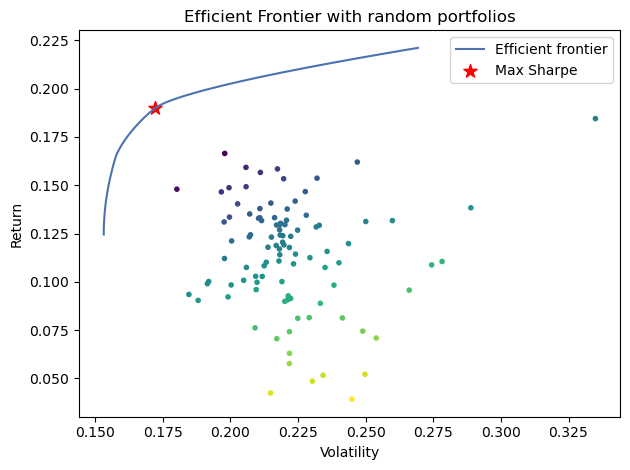

In [4]:
import pypfopt.plotting as plotting
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()
ef_max_sharpe = ef.deepcopy()
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=False)

# Find the tangency portfolio
ef_max_sharpe.max_sharpe()
ret_tangent, std_tangent, _ = ef_max_sharpe.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Max Sharpe")

# Generate random portfolios
n_samples = 100
w = np.random.dirichlet(np.ones(ef.n_assets), n_samples)
rets = w.dot(ef.expected_returns)
stds = np.sqrt(np.diag(w @ ef.cov_matrix @ w.T))
sharpes = rets / stds
ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")

# Output
ax.set_title("Efficient Frontier with random portfolios")
ax.legend()
plt.tight_layout()
#plt.savefig("ef_scatter.png", dpi=200)
plt.show()

In [5]:
# Optimize for maximum Sharpe ratio

#weights = ef.max_sharpe()

#  print weights
cleaned_weights = ef_max_sharpe.clean_weights()
print(cleaned_weights)

OrderedDict([('AAPL', 0.2), ('AMD', 0.00143), ('BA', 0.0), ('BAC', 0.0), ('GE', 0.0), ('GOOG', 0.2), ('JPM', 0.0), ('MU', 0.0), ('PFE', 0.19374), ('RRC', 0.0), ('SBUX', 0.2), ('T', 0.00482), ('UAA', 0.0), ('WMT', 0.2), ('XOM', 0.0)])


In [6]:
#to know the expected performance of the portfolio with optimal weights w
ef_max_sharpe.portfolio_performance(verbose=True)

Expected annual return: 19.0%
Annual volatility: 17.2%
Sharpe Ratio: 0.99


(0.18984927742885593, 0.17215221192385616, 0.9866226842556121)

In [7]:
# Calculate the discrete allocation of assets based on the optimal weights
latest_prices = historical_prices.iloc[-1]  # Latest prices for the assets
da = DiscreteAllocation(cleaned_weights, latest_prices, total_portfolio_value=10000)
allocation, leftover = da.greedy_portfolio()

In [8]:
print("Optimal Allocation:", allocation)
print("Leftover:",leftover)

Optimal Allocation: {'AAPL': 22, 'GOOG': 28, 'SBUX': 29, 'WMT': 18, 'PFE': 70, 'T': 2, 'AMD': 1}
Leftover: 14.65380859375


[*********************100%***********************]  1 of 1 completed


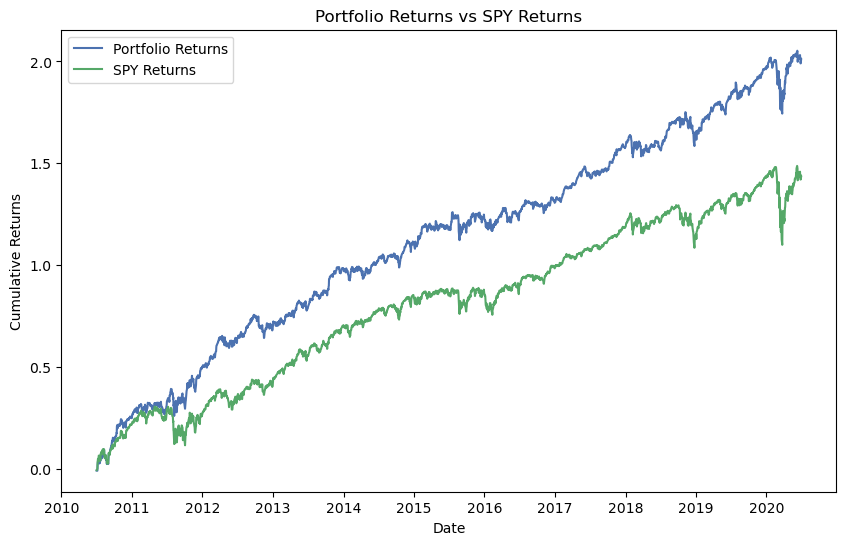

In [9]:
# Download benchmark data
spy_data = yf.download('SPY', start=start_date, end=end_date)['Adj Close']

# Calculate portfolio and benchmark returns
portfolio_returns = (historical_prices.pct_change().dropna() * cleaned_weights).sum(axis=1)
benchmark_returns = spy_data.pct_change().dropna()

# Plot the returns
plt.figure(figsize=(10, 6), facecolor='none')
plt.plot(portfolio_returns.cumsum(), label='Portfolio Returns')
plt.plot(benchmark_returns.cumsum(), label='SPY Returns')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.title('Portfolio Returns vs SPY Returns')
# Remove background grid lines
plt.grid(visible=False)
#plt.savefig('portfolio_vs_spy.png', transparent=True)

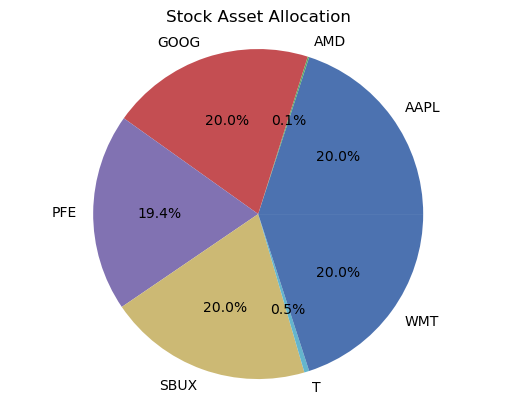

In [10]:
filtered_dict = {key: value for key, value in cleaned_weights.items() if value != 0}
labels = list(filtered_dict.keys()) 
values = list(filtered_dict.values())
plt.pie(values, labels=labels, autopct='%1.1f%%')
plt.title('Stock Asset Allocation')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

# Testing on data from July 2020 to June 2023 with monthly rebalancing in empyrial. 

Start date: 2020-7-01
End date: 2023-06-30


,Backtest
,
Annual return,17.95%
Cumulative return,60.27%
Annual volatility,18.92 %
Winning day ratio,53.33%
Sharpe ratio,0.97
Calmar ratio,0.71
Information ratio,0.0
Stability,0.5
Max Drawdown,-24.0 %


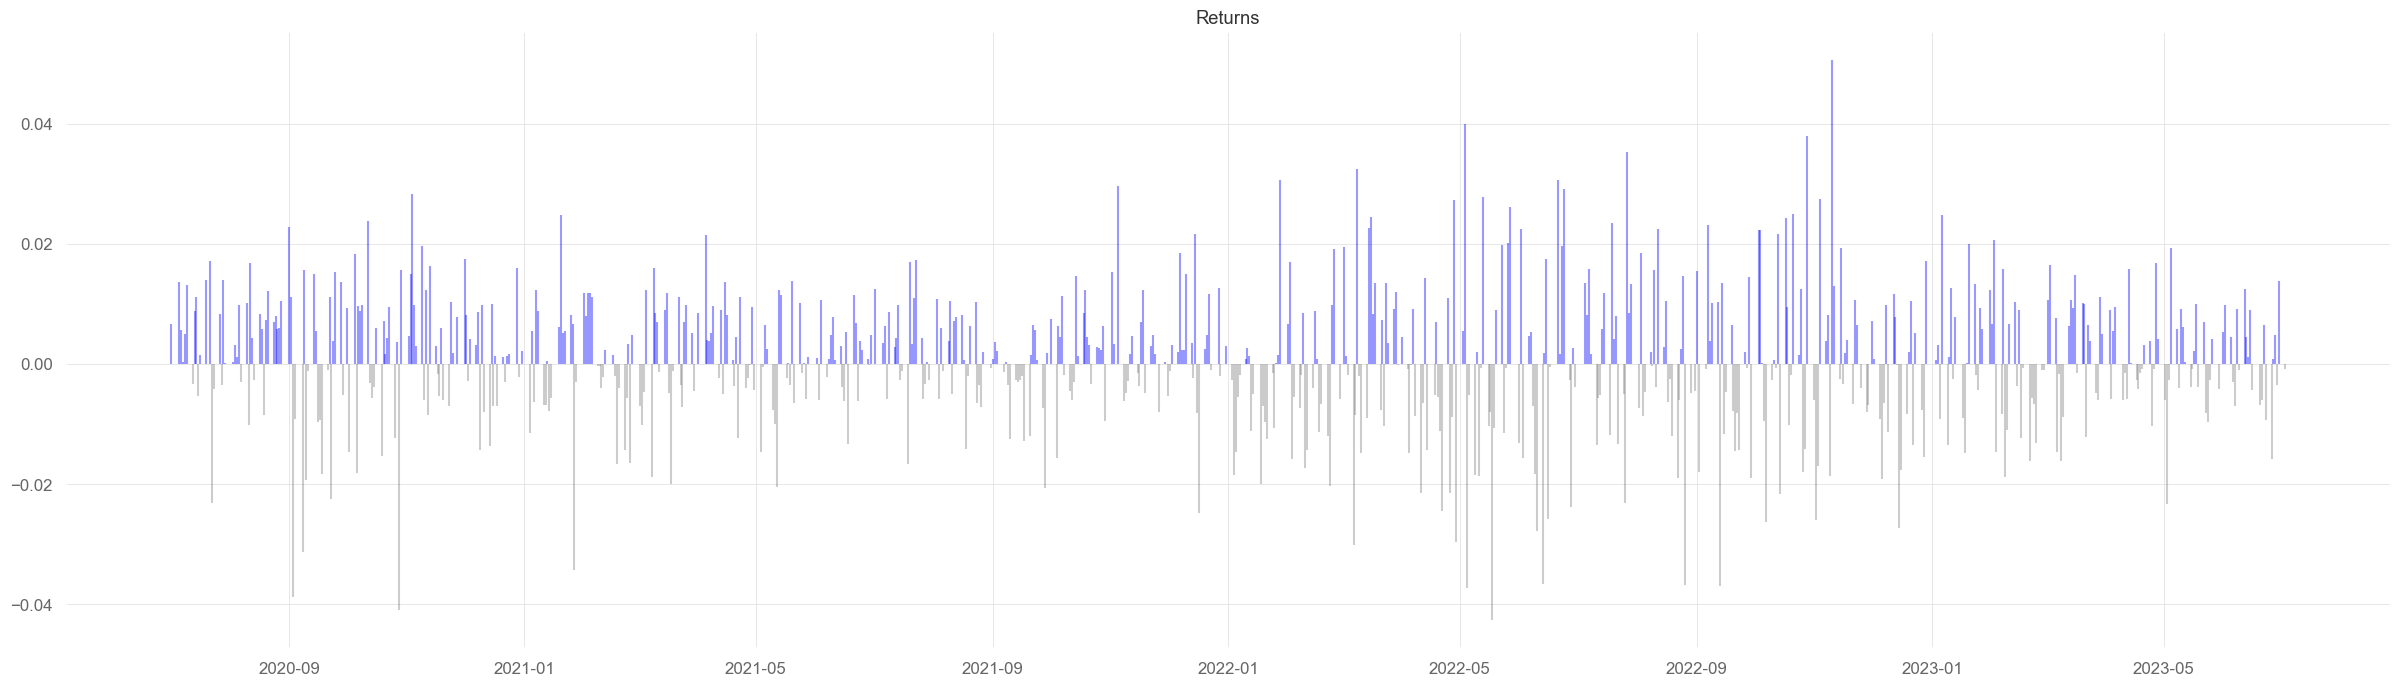

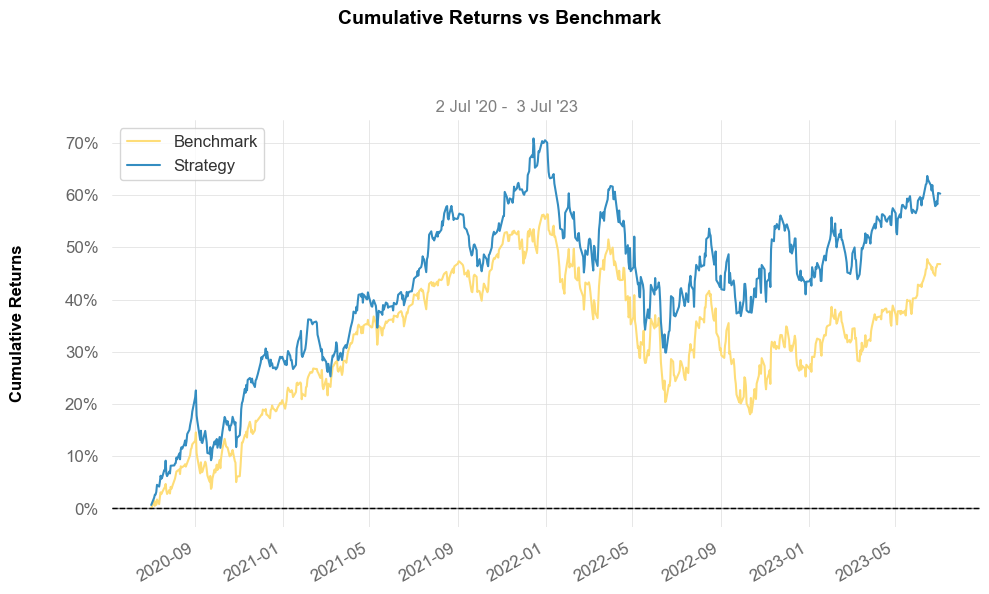

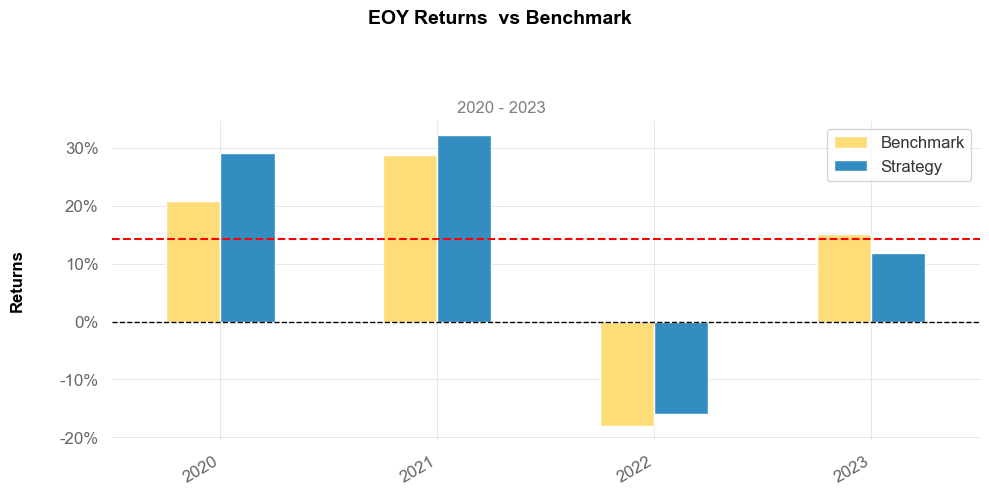

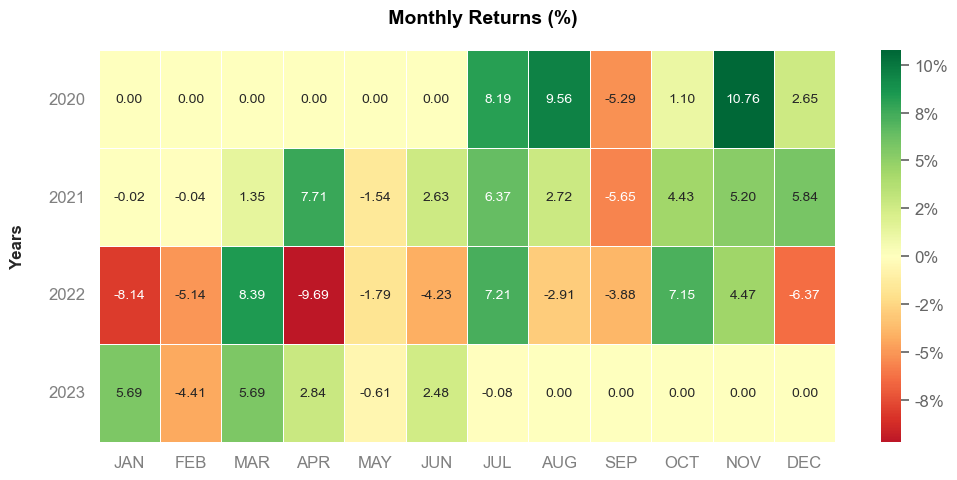

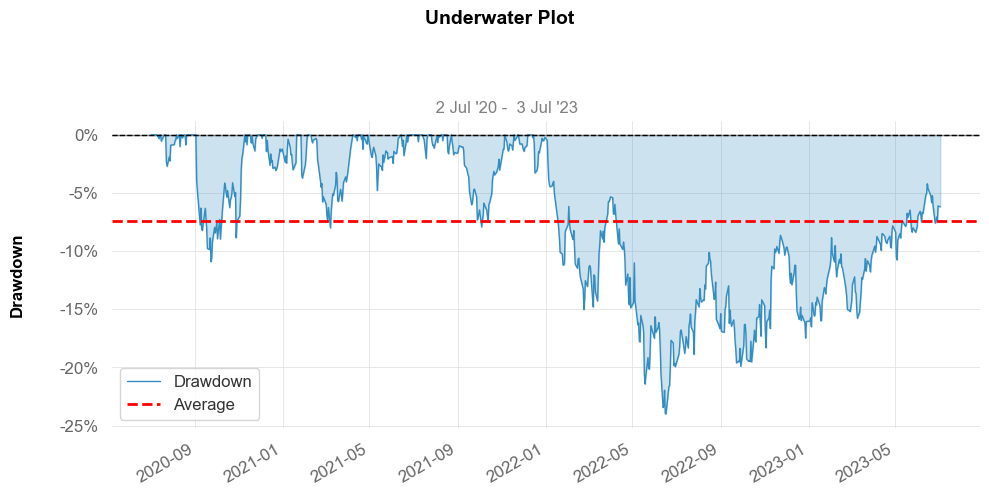

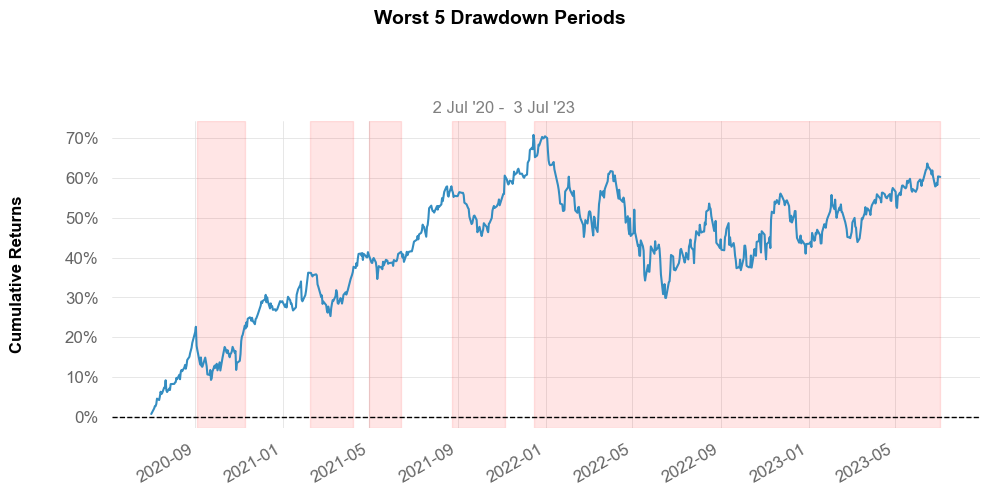

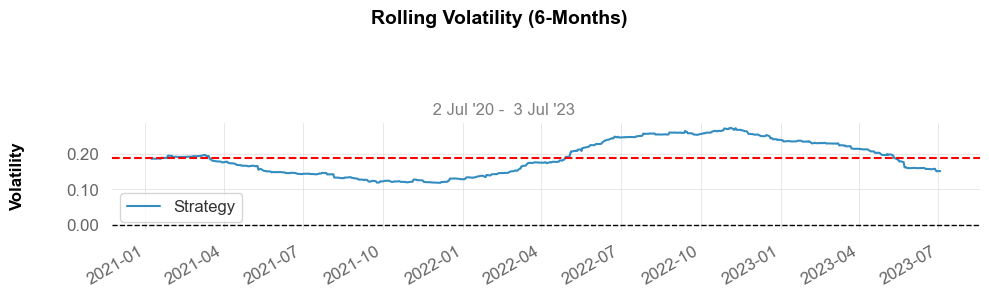

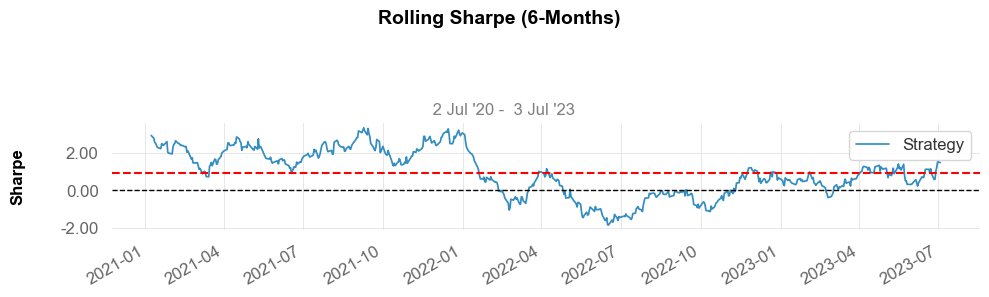

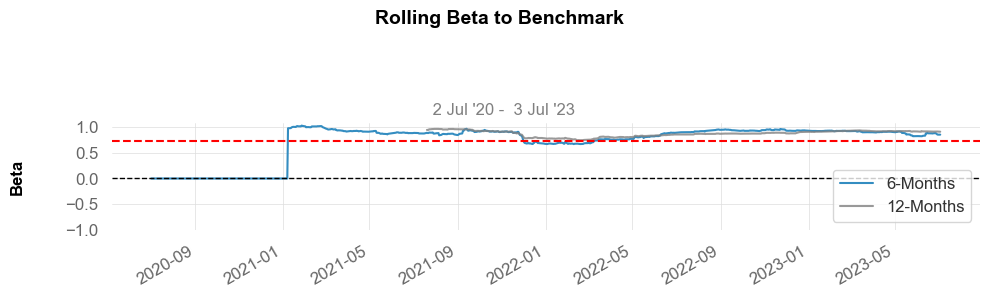

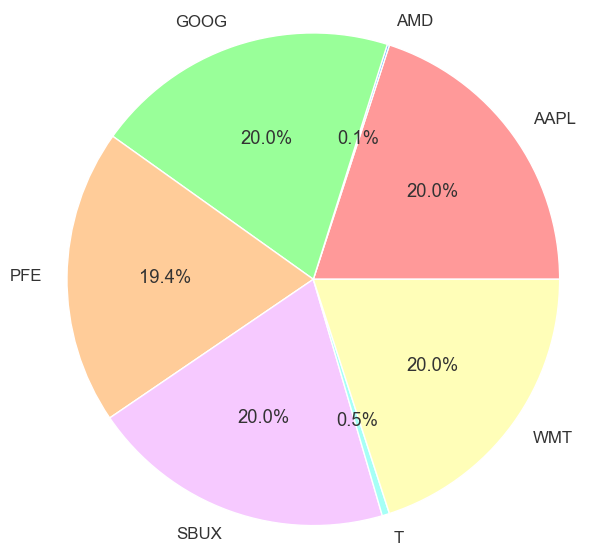

(None, None, None, None, None, None, None, None, None)

In [11]:
portfolio_tickers = list(cleaned_weights.keys()) 
portfolio_weights = list(cleaned_weights.values())

import datetime
from empyrial import empyrial, Engine
portfolio = Engine(
      start_date = "2020-7-01",
      #optimizer = "MEANVAR",
      end_date=datetime.date(2023, 6, 30),
      #max_weights=0.2,
      #max_vol = 0.20,
      rebalance = "monthly",
      portfolio = portfolio_tickers,
      weights = portfolio_weights,
      benchmark = ["SPY"]
)
#portfolio.weights

empyrial(portfolio)

# 1/N model

Start date: 2020-7-01
End date: 2023-06-30


,Backtest
,
Annual return,27.64%
Cumulative return,100.82%
Annual volatility,21.56 %
Winning day ratio,52.78%
Sharpe ratio,1.24
Calmar ratio,1.04
Information ratio,0.0
Stability,0.56
Max Drawdown,-25.21 %


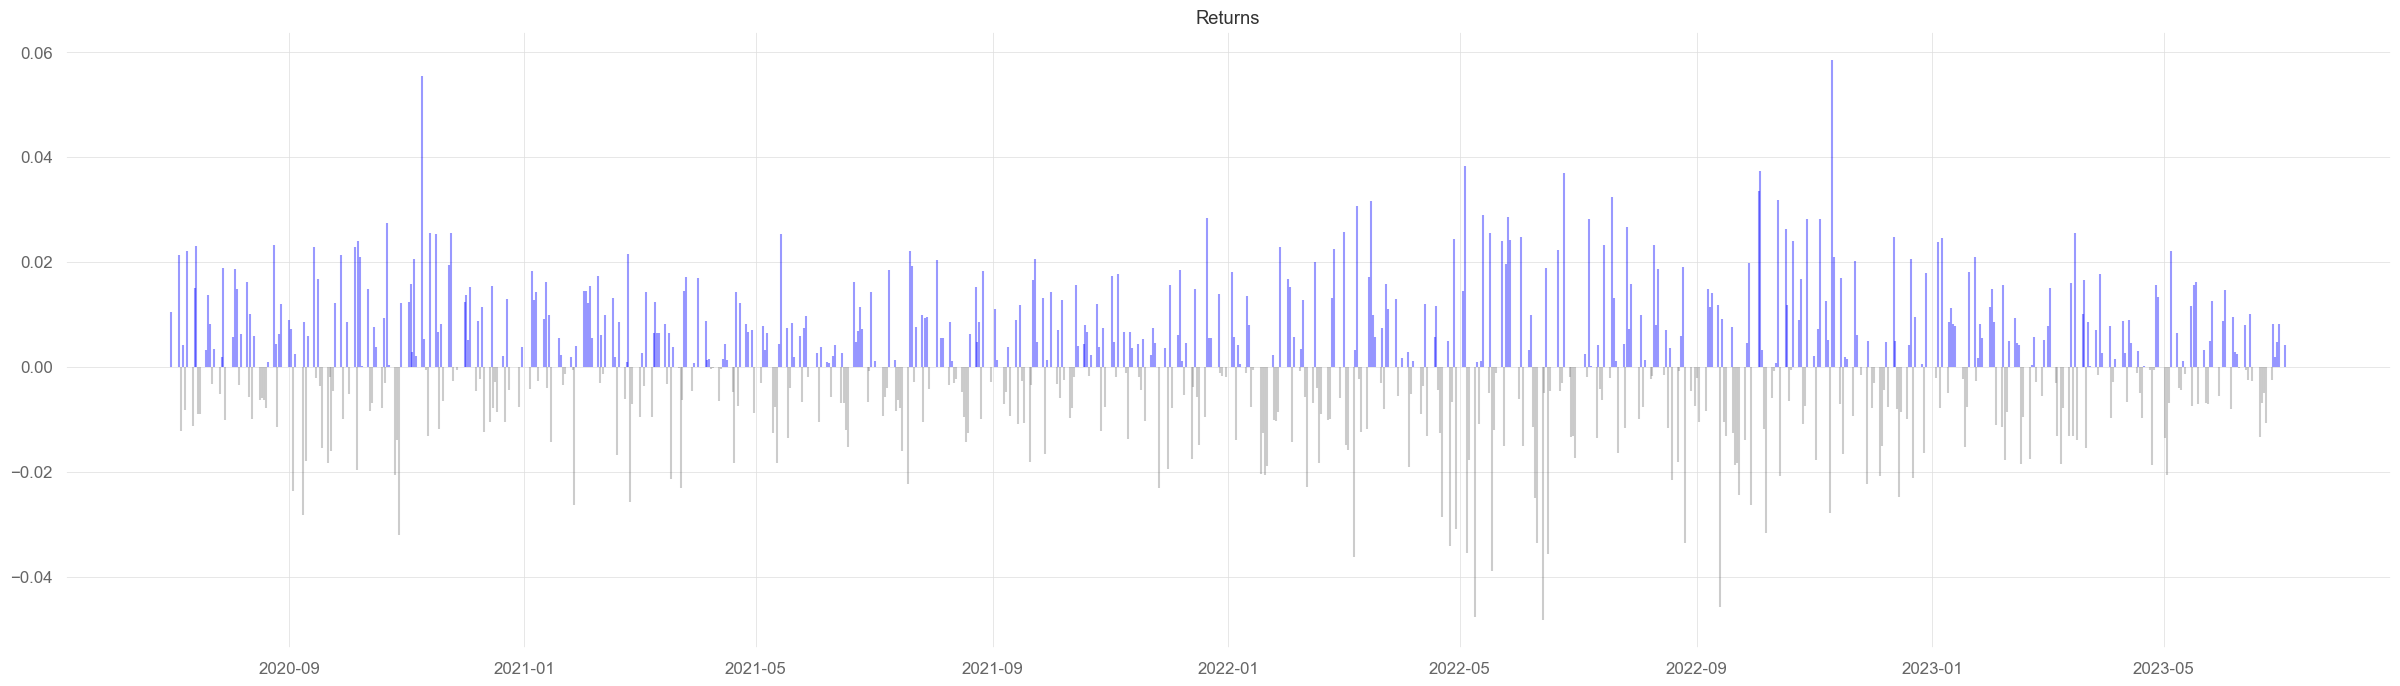

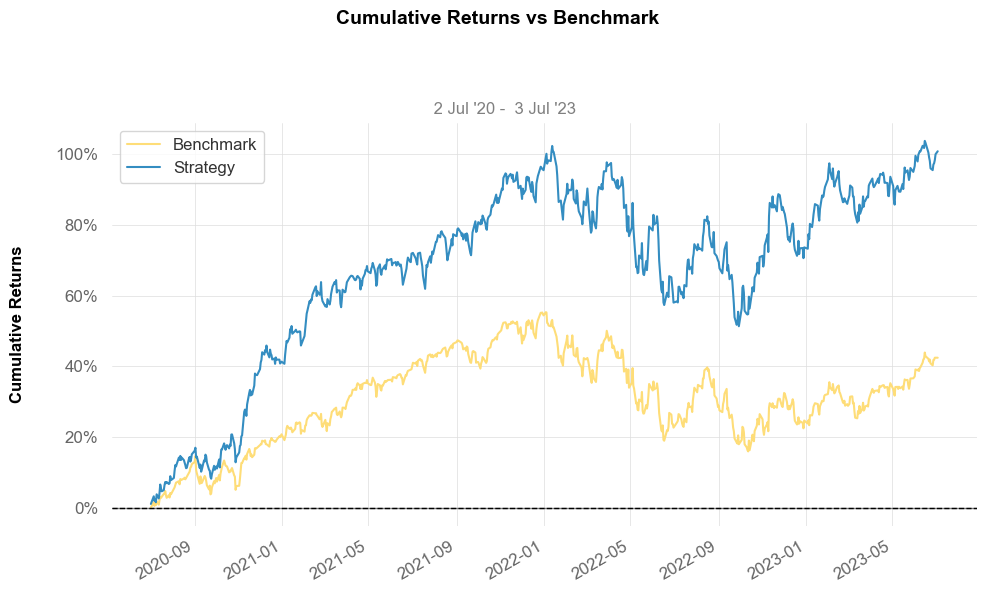

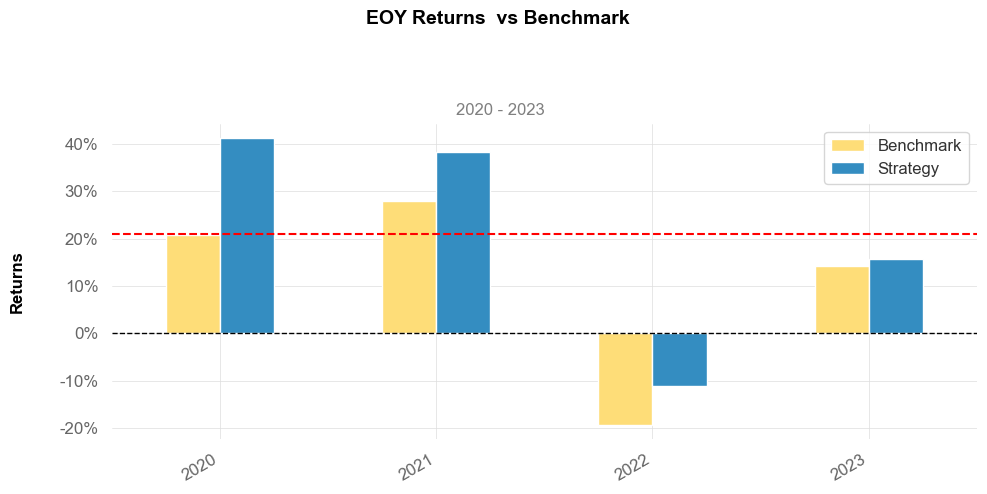

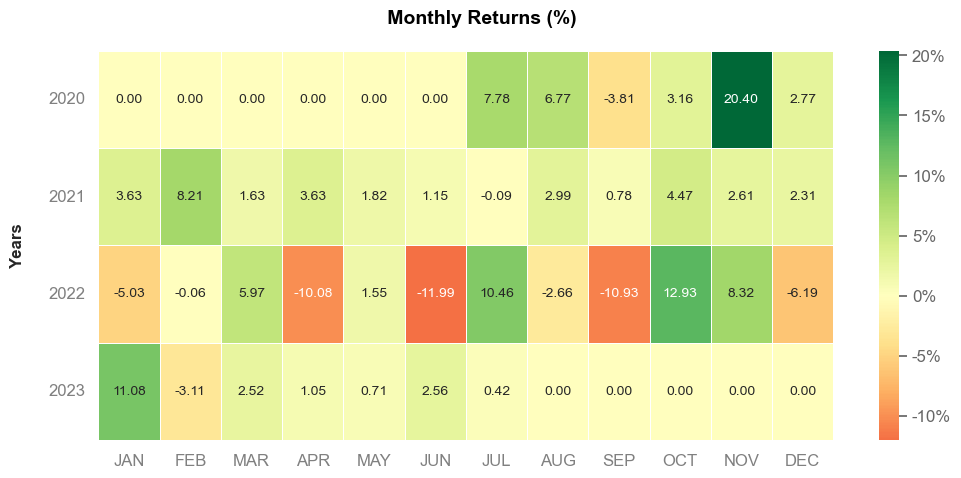

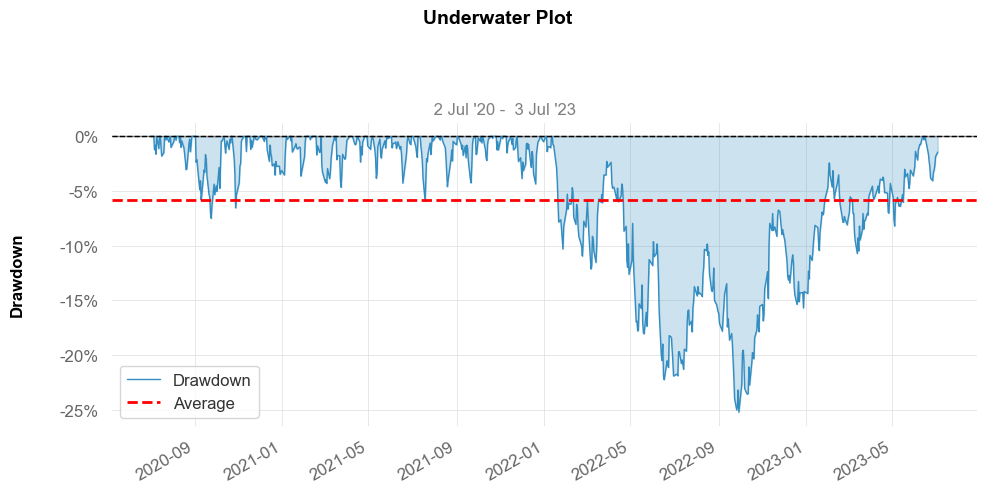

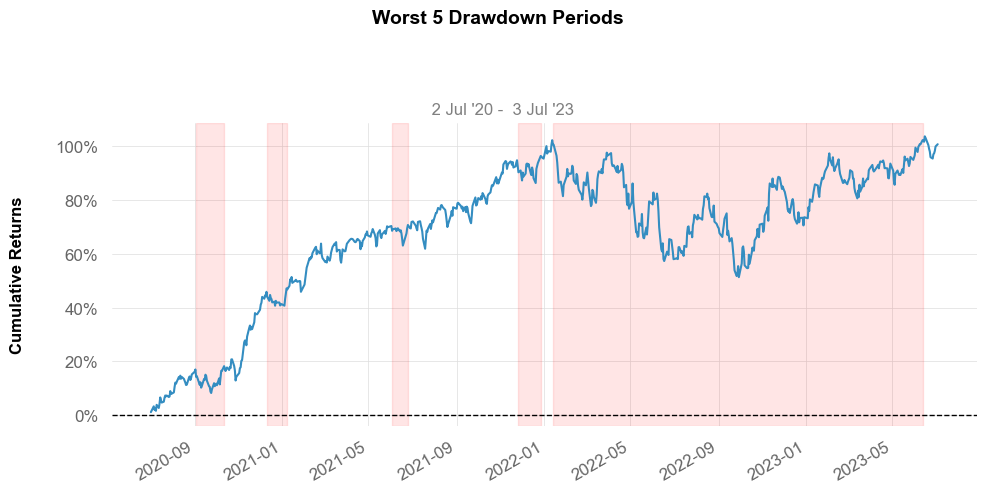

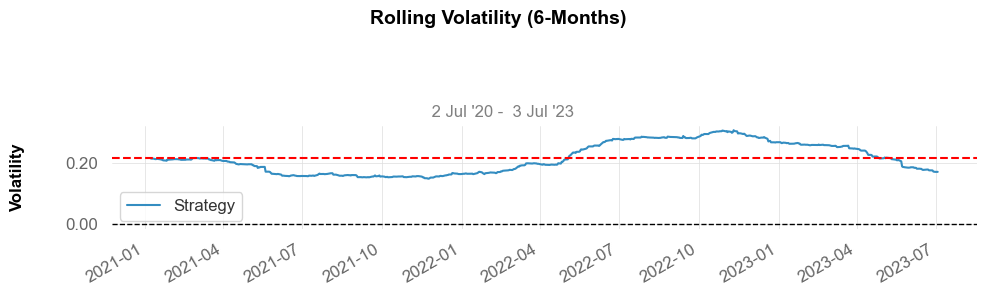

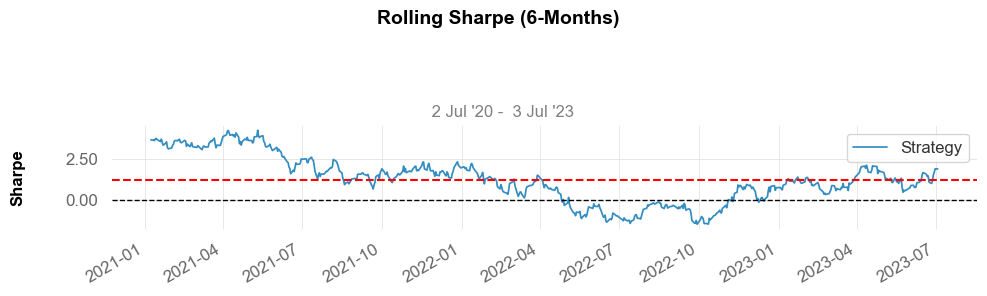

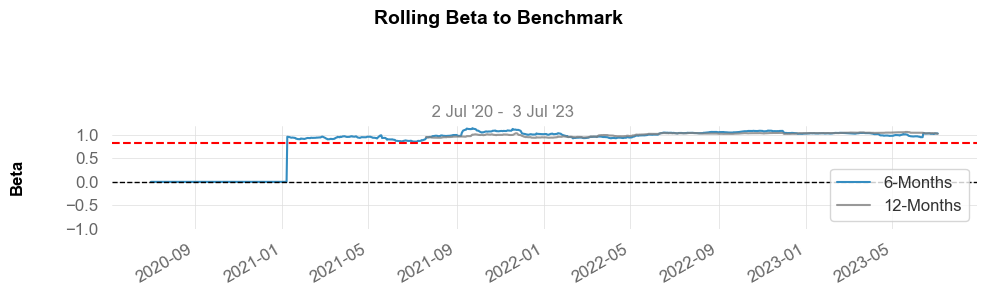

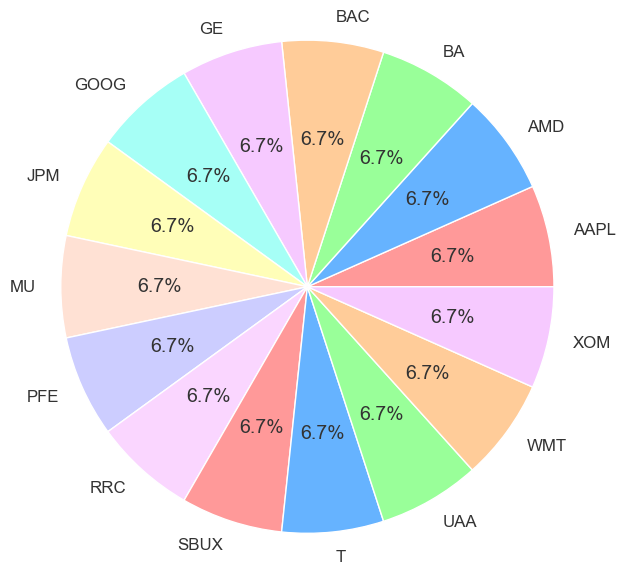

(None, None, None, None, None, None, None, None, None)

In [12]:
import datetime
from empyrial import empyrial, Engine
portfolio = Engine(
      start_date = "2020-7-01",
      #optimizer = "MEANVAR",
      end_date=datetime.date(2023, 6, 30),
      #max_weights=0.2,
      #max_vol = 0.20,
      rebalance = "monthly",
      portfolio = ['AAPL','AMD','BA','BAC', 'GE','GOOG','JPM','MU','PFE','RRC','SBUX','T','UAA','WMT','XOM'],
      #weights = portfolio_weights,
      benchmark = ["SPY"]
)
#portfolio.weights

empyrial(portfolio)

In [13]:
def utility_optimal_portfolio(risk_aversion_coeff):
    # Importing libraries
    #from pypfopt import EfficientFrontier
    #from pypfopt import risk_models
    #from pypfopt import expected_returns
    #from pypfopt import objective_functions
    #latest_prices = historical_prices.iloc[-1]
 
    # Expected Returns
    #mu = expected_returns.mean_historical_return(pf_data)
    # Expected Volatility
    #Sigma = risk_models.sample_cov(pf_data)
    ef_ = EfficientFrontier(returns, cov_matrix)  # setup
    ef_.add_objective(objective_functions.L2_reg)  # add a secondary objective
    weights = ef_.max_quadratic_utility(risk_aversion=risk_aversion_coeff, market_neutral=False)  # find the portfolio that maximizes utility
    ret,vol,sharpe_r = ef_.portfolio_performance()
    da = DiscreteAllocation(weights, latest_prices, total_portfolio_value=10000)
    allocation, leftover = da.greedy_portfolio()
    # loop to iterate for values  
    res = dict() 
    for key in weights:  
    # rounding to K using round() 
        res[key] = round(weights[key], 2) 
    
    return "Allocation " + str(res),'Annualised Reutrn ' + str(round(ret,2)),'Annualised Volatility ' + str(round(vol,2)),'Sharpe Ratio ' + str(round(sharpe_r,2)),'Allocation ' + str(allocation),'Leftover fund ' + str(leftover) 

In [14]:
# Aggressive Investor
utility_optimal_portfolio(1)

("Allocation {'AAPL': 0.15, 'AMD': 0.09, 'BA': 0.08, 'BAC': 0.03, 'GE': 0.0, 'GOOG': 0.11, 'JPM': 0.07, 'MU': 0.09, 'PFE': 0.08, 'RRC': 0.0, 'SBUX': 0.11, 'T': 0.06, 'UAA': 0.04, 'WMT': 0.08, 'XOM': 0.02}",
 'Annualised Reutrn 0.18',
 'Annualised Volatility 0.21',
 'Sharpe Ratio 0.74',
 "Allocation {'AAPL': 16, 'SBUX': 16, 'GOOG': 16, 'AMD': 19, 'MU': 18, 'WMT': 7, 'PFE': 27, 'BA': 4, 'JPM': 8, 'T': 35, 'UAA': 45, 'BAC': 14, 'XOM': 4}",
 'Leftover fund 5.375543594360352')

In [15]:
# Moderate Investor
utility_optimal_portfolio(4)

("Allocation {'AAPL': 0.15, 'AMD': 0.06, 'BA': 0.07, 'BAC': 0.02, 'GE': 0.0, 'GOOG': 0.11, 'JPM': 0.06, 'MU': 0.06, 'PFE': 0.1, 'RRC': 0.0, 'SBUX': 0.12, 'T': 0.09, 'UAA': 0.03, 'WMT': 0.11, 'XOM': 0.03}",
 'Annualised Reutrn 0.17',
 'Annualised Volatility 0.19',
 'Sharpe Ratio 0.78',
 "Allocation {'AAPL': 16, 'SBUX': 17, 'GOOG': 16, 'WMT': 9, 'PFE': 35, 'T': 48, 'BA': 4, 'JPM': 8, 'AMD': 12, 'MU': 12, 'UAA': 34, 'XOM': 7, 'BAC': 9}",
 'Leftover fund 3.7211227416992188')

In [16]:
# Risk-Averse Investor
utility_optimal_portfolio(10)

("Allocation {'AAPL': 0.14, 'AMD': 0.03, 'BA': 0.05, 'BAC': 0.0, 'GE': 0.0, 'GOOG': 0.12, 'JPM': 0.06, 'MU': 0.02, 'PFE': 0.12, 'RRC': 0.0, 'SBUX': 0.12, 'T': 0.12, 'UAA': 0.02, 'WMT': 0.15, 'XOM': 0.05}",
 'Annualised Reutrn 0.16',
 'Annualised Volatility 0.17',
 'Sharpe Ratio 0.83',
 "Allocation {'WMT': 13, 'AAPL': 16, 'PFE': 45, 'SBUX': 17, 'GOOG': 17, 'T': 65, 'JPM': 7, 'BA': 3, 'XOM': 12, 'AMD': 6, 'MU': 4, 'UAA': 19}",
 'Leftover fund 25.21259117126465')

## Markowitz with Target Volatility

In [17]:
# Prepare historical price data for assets
#historical_prices = pd.read_csv('historical_prices.csv', index_col=0, parse_dates=True)
#historical_prices = data
target_volatility = 0.2


# Calculate expected returns
#returns = expected_returns.mean_historical_return(historical_prices)
#cov_matrix = risk_models.sample_cov(historical_prices)

# Create an instance of EfficientFrontier
ef_tv = EfficientFrontier(returns, cov_matrix,weight_bounds = (0,0.2))

# add a secondary objective
ef_tv.add_objective(objective_functions.L2_reg)

ef_tv.efficient_risk(target_volatility)

OrderedDict([('AAPL', 0.1462505213756777),
             ('AMD', 0.0750858472473974),
             ('BA', 0.0716447958739305),
             ('BAC', 0.0255118546507518),
             ('GE', 9.06324e-10),
             ('GOOG', 0.1119055855428234),
             ('JPM', 0.0661806376280583),
             ('MU', 0.0704945860298941),
             ('PFE', 0.0878201055556165),
             ('RRC', 1.254888e-10),
             ('SBUX', 0.1172391688185781),
             ('T', 0.0745379482515823),
             ('UAA', 0.0385827652146904),
             ('WMT', 0.0926328886089768),
             ('XOM', 0.0221132941701214)])

In [18]:
#plotting.plot_efficient_frontier(ef_tv, show_assets=True, show_tickers=True)

In [19]:
#  print weights
cleaned_weights = ef_tv.clean_weights()
print(cleaned_weights)

OrderedDict([('AAPL', 0.14625), ('AMD', 0.07509), ('BA', 0.07164), ('BAC', 0.02551), ('GE', 0.0), ('GOOG', 0.11191), ('JPM', 0.06618), ('MU', 0.07049), ('PFE', 0.08782), ('RRC', 0.0), ('SBUX', 0.11724), ('T', 0.07454), ('UAA', 0.03858), ('WMT', 0.09263), ('XOM', 0.02211)])


In [20]:
#to know the expected performance of the portfolio with optimal weights w
ef_tv.portfolio_performance(verbose=True)

Expected annual return: 17.3%
Annual volatility: 20.0%
Sharpe Ratio: 0.76


(0.17286680762202342, 0.20000000044923288, 0.7643340363932972)

In [21]:
# Calculate the discrete allocation of assets based on the optimal weights
#latest_prices = historical_prices.iloc[-1]  # Latest prices for the assets
da = DiscreteAllocation(cleaned_weights, latest_prices, total_portfolio_value=10000)
allocation, leftover = da.greedy_portfolio()

In [22]:
print("Optimal Allocation:", allocation)
print("Leftover:",leftover)

Optimal Allocation: {'AAPL': 16, 'SBUX': 17, 'GOOG': 16, 'WMT': 8, 'PFE': 32, 'AMD': 15, 'T': 42, 'BA': 4, 'MU': 14, 'JPM': 8, 'UAA': 39, 'BAC': 11, 'XOM': 6}
Leftover: 3.9516239166259766


# Find weights for different periods

In [23]:
start_date ='2022-7-1'
end_date ='2023-6-30'

# Fetch the data
import yfinance as yf
data_diff = yf.download(tickers_list,start = start_date,end = end_date)['Adj Close']

monthly_prices = data_diff.copy()
#monthly_prices['MonthNumber'] = historical_prices.index.month
#monthly_prices['YearNumber'] = historical_prices.index.year
#monthly_prices["Concatkey"] = monthly_prices['MonthNumber'].astype(str) +"-"+ monthly_prices["YearNumber"].astype(str)
#grouped_monthly_prices = monthly_prices.groupby(['Concatkey'],sort=False)
'''for month_year, group in grouped_monthly_prices:
    # Print the month number and the corresponding group data
    #print(f"Month: {month_year}")
    #print(group)
    prices_new = group
    #prices_new = prices.copy()
    prices_new = prices_new.loc[:, ~prices_new.columns.isin(['MonthNumber', 'YearNumber',' Concatkey'])]
    print(prices_new)'''
'''for month, group in monthly_prices.groupby(pd.Grouper(freq='3M')):
    # Print the month and the corresponding group data
    print(f"Month: {month}")
    print(group)
    print()'''

[*********************100%***********************]  15 of 15 completed


'for month, group in monthly_prices.groupby(pd.Grouper(freq=\'3M\')):\n    # Print the month and the corresponding group data\n    print(f"Month: {month}")\n    print(group)\n    print()'

In [24]:
# Create an empty DataFrame to store allocation results
allocation_history = pd.DataFrame(columns=tickers_list)

# Set initial portfolio value
portfolio_value = 10000

# Set rebalancing frequency (in months)
#rebalancing_frequency = 1

# Iterate over each month
for month, group in monthly_prices.groupby(pd.Grouper(freq='Q')):
    prices = group
    #prices_new = prices.copy()
    #prices_new = prices_new.loc[:, ~prices_new.columns.isin(['MonthNumber','YearNumber','Concatkey'])]
    #target_volatility = 0.2
    
    # Calculate expected returns and covariance matrix
    returns = expected_returns.mean_historical_return(prices)
    cov_matrix = risk_models.sample_cov(prices)

    # Create an instance of EfficientFrontier
    ef = EfficientFrontier(returns, cov_matrix, weight_bounds=(0, 0.2))

    #ef.add_objective(objective_functions.L2_reg)
    
    # Optimize for maximum Sharpe ratio
    weights = ef.max_sharpe()

    #ef.efficient_risk(target_volatility)
    
    # Clean the weights for assets below the lower weight bound
    cleaned_weights = ef.clean_weights()

    # Calculate the discrete allocation of assets based on the optimal weights
    #latest_prices = prices.iloc[-1]  # Latest prices for the assets
    #da = DiscreteAllocation(cleaned_weights, latest_prices, total_portfolio_value=portfolio_value)
    #allocation, _ = da.greedy_portfolio()

    # Store the allocation for the current month
    allocation_history = allocation_history.append(cleaned_weights, ignore_index=True)

# Print the allocation history
print(allocation_history)

   AAPL      WMT   MU   BA  GOOG       GE      AMD  BAC        T      UAA  \
0   0.2  0.20000  0.0  0.0   0.0  0.01625  0.00000  0.0  0.00000  0.00000   
1   0.0  0.00000  0.0  0.2   0.0  0.20000  0.00000  0.0  0.15848  0.06337   
2   0.2  0.14229  0.0  0.0   0.0  0.20000  0.20000  0.0  0.14235  0.00000   
3   0.2  0.20000  0.0  0.0   0.2  0.20000  0.02276  0.0  0.00000  0.00000   

       XOM      RRC  PFE      JPM  SBUX  
0  0.20000  0.18375  0.0  0.00000   0.2  
1  0.11485  0.00000  0.2  0.06330   0.0  
2  0.11535  0.00000  0.0  0.00000   0.0  
3  0.00000  0.03942  0.0  0.13783   0.0  
